In [150]:
import pandas as pd
import os
import urllib
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np
from scipy.signal import periodogram
import statsmodels.api as sm
import dask.dataframe as dd
import matplotlib.patches as patches
import statistics
import geopandas as gpd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import warnings
warnings.filterwarnings('ignore')

In [2]:
master=pd.read_csv(r'C:\Users\Jose Ramon Romero P\Documents\NYU\Semester 2\Capstone 1\NYC-Rezoning-evaluation\data\mappluto_nyc\mappluto_nyc\master_pre_model2010_2017.csv')

# Filtering lots that are in all the four years we are using

In [3]:
master['count']=1

In [4]:
pv=pd.pivot_table(master,values='count',index=['bbl'],columns=['year_x'],aggfunc=np.sum)
pv['total']=pv.sum(axis=1)


In [5]:
pv=pv.reset_index()[['bbl','total']]
pv=pv[pv.total==4]

# Filtering master with lots that are for all the years

In [6]:
master.shape

(3245386, 44)

In [7]:
master=pd.merge(master,pv,on='bbl').iloc[:,2:-2]

In [8]:
master.columns

Index(['bbl', 'geoid', 'year_x', 'easements', 'lotarea', 'lotfront',
       'lotdepth', 'assessland', 'assesstot', 'yearbuilt', 'builtfar',
       'med_income', 'housing_units', 'subway_acc', 'noisePerCapita',
       'built_green', 'maxfar', 'low_educ', 'comm_built_far', 'res_built_far',
       'office_built_far', 'retail_built_far', 'garage_built_far',
       'storage_built_far', 'factry_built_far', 'zon_Commercial',
       'zon_Manufacturing', 'zon_Mixed', 'zon_Other', 'zon_Residential',
       'land_use_1.0', 'land_use_2.0', 'land_use_3.0', 'land_use_4.0',
       'land_use_5.0', 'land_use_6.0', 'land_use_7.0', 'land_use_8.0',
       'land_use_9.0', 'land_use_10.0', 'land_use_11.0'],
      dtype='object')

# Creating a yearly dataset by available year

In [9]:
def year_dataset(master,new_year):
    new=master[master.year_x==new_year]
    new=new.drop(['geoid','year_x'],axis=1)
    new_name={name:name+'_'+str(new_year)[2:] for name in new.columns[1:]}
    new=new.rename(new_name,axis=1)
    return new
    

In [10]:
def diff_dt(master,first,second,filterv=False):
    diff_var=[ 'assessland', 'assesstot', 'builtfar', 'maxfar', 'comm_built_far', 'res_built_far',
       'office_built_far', 'retail_built_far', 'garage_built_far',
       'storage_built_far', 'factry_built_far']
    intermediate_var=[ 'easements', 'lotarea', 'lotfront',
       'lotdepth',  'yearbuilt', 'med_income', 'housing_units', 'subway_acc', 'noisePerCapita',
       'built_green', 'low_educ',  'zon_Commercial',
       'zon_Manufacturing', 'zon_Mixed', 'zon_Other', 'zon_Residential',
       'land_use_1.0', 'land_use_2.0', 'land_use_3.0', 'land_use_4.0',
       'land_use_5.0', 'land_use_6.0', 'land_use_7.0', 'land_use_8.0',
       'land_use_9.0', 'land_use_10.0', 'land_use_11.0']
    first_dt=year_dataset(master,first)
    second_dt=year_dataset(master,second)
    merge=pd.merge(first_dt,second_dt,on='bbl')
    for var in diff_var:
        merge['diff_'+str(first)[2:]+str(second)[2:]+'_'+var]=(merge[var+'_'+str(second)[2:]]-merge[var+'_'+str(first)[2:]])
    if filterv==False:
        drop_var=[var+'_'+str(second)[2:] for var in diff_var]
        merge=merge.drop(drop_var,axis=1)
    elif filterv==True:
        drop_var=[var+'_'+str(second)[2:] for var in diff_var]
        merge=merge.drop(drop_var,axis=1)
        drop_var2=[var+'_'+str(first)[2:] for var in intermediate_var]
        merge=merge.drop(drop_var2,axis=1)
        drop_var=[var+'_'+str(first)[2:] for var in diff_var]
        merge=merge.drop(drop_var,axis=1)
    return merge

In [11]:
df1012=diff_dt(master,2010,2012,filterv=False)
df1012.shape

(802180, 77)

In [12]:
df1214=diff_dt(master,2012,2014,filterv=True)
df1214.shape

(802180, 39)

In [13]:
df17=year_dataset(master,2017)[['bbl','comm_built_far_17', 'res_built_far_17','lotarea_17','maxfar_17']]

In [14]:
model=pd.merge(df1012,df1214,on='bbl')
model=pd.merge(model,df17,on='bbl')

# Validation

In [131]:
model

,Unnamed: 0_x,bbl,easements_10,lotarea_10,lotfront_10,lotdepth_10,assessland_10,assesstot_10,yearbuilt_10,builtfar_10,...,diff_1214_factry_built_far,comm_built_far_17,res_built_far_17,lotarea_17,maxfar_17,diff,Unnamed: 0_y,geoid,borough,zipcode
0,0,2.022600e+09,0,45053,301.42,76.58,270450.0,297900.0,1931,0.02,...,0.0,0.019089,0.000000,45053,2.0,0.0,6113878,360050019004,BX,10454
1,1,2.023160e+09,0,133700,333.08,430.00,450000.0,1804500.0,1966,0.62,...,0.0,0.621272,0.000000,133700,7.2,0.0,6113861,360050019004,BX,10454
2,2,2.025830e+09,0,350500,377.00,986.00,3154500.0,63900000.0,1999,1.27,...,0.0,1.275735,0.000000,350500,2.0,0.0,6113876,360050019004,BX,10454
3,3,2.025430e+09,2,54543,439.87,124.00,268650.0,1300500.0,1952,0.88,...,0.0,0.913758,0.000000,54556,2.0,0.0,6113864,360050019004,BX,10454
4,4,2.022600e+09,0,153200,197.00,567.58,765000.0,2326500.0,1967,0.64,...,0.0,0.639687,0.000000,153200,2.0,0.0,6113847,360050019004,BX,10454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802175,802175,5.031110e+09,0,5000,50.00,100.00,14128.0,24177.0,1960,0.55,...,0.0,0.000000,0.550400,5000,1.0,0.4,6901447,360850074001,SI,10305
802176,802176,5.031220e+09,0,3100,29.00,112.00,12007.0,19578.0,1999,0.60,...,0.0,0.000000,0.490000,3100,1.0,0.4,6901347,360850074001,SI,10305
802177,802177,5.031110e+09,0,1400,14.00,100.00,11444.0,16336.0,1986,0.80,...,0.0,0.000000,0.800000,1400,1.0,0.4,6901160,360850074001,SI,10305
802178,802178,5.031220e+09,0,2475,23.00,100.00,15420.0,26460.0,2000,0.89,...,0.0,0.000000,0.595556,2475,1.0,0.4,6946734,360850074001,SI,10305


In [15]:
model['diff']=model.maxfar_17-model.maxfar_10

In [16]:
model.to_csv(r'C:\Users\Jose Ramon Romero P\Documents\NYU\Semester 2\Capstone 1\NYC-Rezoning-evaluation\data\mappluto_nyc\mappluto_nyc\model_viz.csv')

In [17]:
m=model.maxfar_17-model.maxfar_10

In [18]:
m[m>0]

25        2.37
26        2.37
27        2.37
28        2.37
29        2.37
          ... 
802175    0.40
802176    0.40
802177    0.40
802178    0.40
802179    0.40
Length: 701512, dtype: float64

In [19]:
a=model.lotarea_17-model.lotarea_10

In [20]:
a[a==0]

0         0
1         0
2         0
4         0
5         0
         ..
802175    0
802176    0
802177    0
802178    0
802179    0
Length: 796922, dtype: int64

In [21]:
f=model.res_built_far_17-model.res_built_far_10

In [22]:
f[(f>3)]

55        5.000000
243       7.415200
643       3.229665
849       3.040000
2180      3.050000
            ...   
586636    5.543010
586712    4.208690
586715    3.279360
588581    3.998652
590129    3.578333
Length: 598, dtype: float64

In [ ]:
f[(f!=0) & (f>-2.5) & (f<5)].hist(bins=60)

# Loading the model dataset

In [2]:
model=pd.read_csv(r'C:\Users\Jose Ramon Romero P\Documents\NYU\Semester 2\Capstone 1\NYC-Rezoning-evaluation\data\mappluto_nyc\mappluto_nyc\model_viz.csv')

In [101]:
model.columns

Index(['Unnamed: 0_x', 'bbl', 'easements_10', 'lotarea_10', 'lotfront_10',
       'lotdepth_10', 'assessland_10', 'assesstot_10', 'yearbuilt_10',
       'builtfar_10',
       ...
       'diff_1214_factry_built_far', 'comm_built_far_17', 'res_built_far_17',
       'lotarea_17', 'maxfar_17', 'diff', 'Unnamed: 0_y', 'geoid', 'borough',
       'zipcode'],
      dtype='object', length=125)

In [10]:
# Loading the bbl,geoid,borough file

In [17]:
keys=pd.read_csv(r'C:\Users\Jose Ramon Romero P\Documents\NYU\Semester 2\Capstone 1\NYC-Rezoning-evaluation\data\mappluto_nyc\mappluto_nyc\bbl_geoid_borough.csv')
keys

,Unnamed: 0,bbl,geoid,borough,zipcode
0,6079004,2.050210e+09,360050448002,BX,10466
1,6079005,2.050210e+09,360050448002,BX,10466
2,6079006,2.050220e+09,360050448002,BX,10466
3,6079007,2.050250e+09,360050448002,BX,10466
4,6079008,2.050240e+09,360050448002,BX,10466
...,...,...,...,...,...
867823,6946827,5.012010e+09,360850223003,SI,0
867824,6946828,5.030720e+09,360850008003,SI,10305
867825,6946829,5.038330e+09,360850112010,SI,10305
867826,6946830,5.011050e+09,360850207000,SI,10302


In [19]:
keys=keys.drop_duplicates(subset=['bbl'])
keys

,Unnamed: 0,bbl,geoid,borough,zipcode
0,6079004,2.050210e+09,360050448002,BX,10466
1,6079005,2.050210e+09,360050448002,BX,10466
2,6079006,2.050220e+09,360050448002,BX,10466
3,6079007,2.050250e+09,360050448002,BX,10466
4,6079008,2.050240e+09,360050448002,BX,10466
...,...,...,...,...,...
867823,6946827,5.012010e+09,360850223003,SI,0
867824,6946828,5.030720e+09,360850008003,SI,10305
867825,6946829,5.038330e+09,360850112010,SI,10305
867826,6946830,5.011050e+09,360850207000,SI,10302


# Train-test split

In [109]:
def features(model,variable):
    if variable=='Residential':
        y=model['res_built_far_17']
    elif variable=='Commercial':
        y=model['comm_built_far_17']
    X=model.iloc[:,1:-2]
    return X,y

In [103]:
def train_test_split_(X,y,proportion):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=proportion) #randomly split data into training (70%) and test (30%)
    return X_train, X_test, y_train, y_test

In [104]:
def scaling(X_train,X_test):
    scalerX=StandardScaler().fit(X_train)
    
    X_train_s=scalerX.transform(X_train)
    X_train_s=pd.DataFrame(X_train_s,columns=X_train.columns)
    
    X_test_s=scalerX.transform(X_test)
    X_test_s=pd.DataFrame(X_test_s,columns=X_train.columns)
    return X_train_s,X_test_s
    

In [105]:
def n_pca(X_train,X_test,n,kernel):
    pca=PCA()
    X_train_pca=pca.fit_transform(X_train)
    eigenvalues=pca.explained_variance_ratio_
    stop=False
    i=0
    cum=0
    while stop==False:
        cum=cum+eigenvalues[i]
        if cum>=n:
            stop=True
            print(cum)
        else:
            i+=1
    X_test_pca=pca.transform(X_test)
    return(i,X_train_pca,X_test_pca)

In [106]:
def linear(X_train,X_test,y_train,y_test):
    lm=sm.OLS(y_train.values,sm.add_constant(X_train)).fit()
    summary=lm.summary()
    y_pred=lm.predict(sm.add_constant(X_test))
    r2=r2_score(y_test,y_pred)
    return summary,r2

In [134]:
def random_forest(X_train,X_test,y_train,y_test):
    rf=RandomForestRegressor().fit(X_train,y_train)
    importances=rf.feature_importances_
    IS_r2=rf.score(X_train,y_train)
    OS_r2=rf.score(X_test,y_test)
    
    return IS_r2,OS_r2,importances

# Train,split, scaling

In [33]:

X,y=features(model_df,'Residential')
X_train, X_test, y_train, y_test = train_test_split_(X,y,0.3)
X_train,X_test=scaling(X_train,X_test)

# PCA

In [45]:
n,X_train_pca,X_test_pca =n_pca(X_train,X_test,n=0.8,kernel='kernel')

0.8010844126483764


In [57]:
X_train_pca=X_train_pca[:,0:n]
X_test_pca=X_test_pca[:,0:n]

In [56]:
X_train_pca[:,0:n].shape

(561526, 25)

In [52]:
X_train_pca.shape

(561526, 117)

In [ ]:
eigenvalues=pca.explained_variance_ratio_
#plot explained variance over the number of compinents
n=60
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

# Linear Model

In [41]:
summary,r2=linear(X_train,X_test,y_train,y_test)
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 3.929e+05
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:30:59   Log-Likelihood:             6.0551e+05
No. Observations:              561526   AIC:                        -1.211e+06
Df Residuals:                  561420   BIC:                        -1.210e+06
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.7958      0.000   7244.044      0.000       0.796       0.796
easements_10                -3.719e+06   5.41e+07     -0.069      0.945    -1.1e+08    1.02e+08
lotarea_10                     -0.0064      0.003     -2.123      0.034      -0.012      -0.000
lotfront_10                     0.0051      0.002      2.823      0.005       0.002       0.009
lotdepth_10                  7.542e-05      0.002      0.033      0.973      -0.004       0.005
assessland_10                   0.0003      0.000      1.081      0.280      -0.000       0.001
assesstot_10                 4.519e-05      0.000      0.162      0.872      -0.001       0.001
yearbuilt_10                    0.0035      0.002      2.286      0.022       0.000       0.006
builtfar_10                    -0.2135      0.272     -0.786      0.432      -0.746       0.319
med_income_10                   0.0006      0.000      2.811      0.005       0.000       0.001
housing_units_10               -0.0021      0.000     -5.630      0.000      -0.003      -0.001
subway_acc_10                 -61.0747    888.317     -0.069      0.945   -1802.148    1679.998
noisePerCapita_10              -0.0013      0.000    -11.053      0.000      -0.002      -0.001
built_green_10                -72.4578   1053.856     -0.069      0.945   -2137.982    1993.067
maxfar_10                      -0.0038      0.000    -20.253      0.000      -0.004      -0.003
low_educ_10                     0.0015      0.000      6.220      0.000       0.001       0.002
comm_built_far_10               0.1141      0.146      0.784      0.433      -0.171       0.399
res_built_far_10                0.1776      0.231      0.770      0.442      -0.275       0.630
office_built_far_10             0.0002      0.000      0.723      0.470      -0.000       0.001
retail_built_far_10             0.0003      0.000      1.329      0.184      -0.000       0.001
garage_built_far_10             0.0003      0.000      1.778      0.075   -2.59e-05       0.001
storage_built_far_10           -0.0002      0.000     -0.871      0.383      -0.001       0.000
factry_built_far_10             0.0003      0.000      1.762      0.078   -3.04e-05       0.001
zon_Commercial_10             425.3761   6186.858      0.069      0.945   -1.17e+04    1.26e+04
zon_Manufacturing_10          398.6180   5797.671      0.069      0.945    -1.1e+04    1.18e+04
zon_Mixed_10                  154.4913   2246.989      0.069      0.945   -4249.535    4558.518
zon_Other_10                   76.0420   1105.989      0.069      0.945   -2091.661    2243.745
zon_Residential_10            597.5085   8690.409      0.069      0.945   -1.64e+04    1.76e+04
land_use_1.0_10              -256.5911   3731.948     -0.069      0.945   -7571.090    7057.908
land_use_2.

In [42]:
r2

0.15768435113344403

In [58]:
summary,r2=linear(X_train_pca,X_test_pca,y_train,y_test)
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     6254.
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:35:06   Log-Likelihood:            -5.3573e+05
No. Observations:              561526   AIC:                         1.072e+06
Df Residuals:                  561500   BIC:                         1.072e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7958      0.001    949.189      0.000       0.794       0.797
x1             0.0436      0.000    174.394      0.000       0.043       0.044
x2            -0.0363      0.000   -125.744      0.000      -0.037      -0.036
x3             0.0763      0.000    229.136      0.000       0.076       0.077
x4            -0.0562      0.000   -159.197      0.000      -0.057      -0.056
x5             0.0268      0.000     66.609      0.000       0.026       0.028
x6             0.0272      0.000     65.628      0.000       0.026       0.028
x7             0.0121      0.000     27.458      0.000       0.011       0.013
x8             0.0012      0.000      2.658      0.008       0.000       0.002
x9            -0.0197      0.000    -42.524      0.000      -0.021      -0.019
x10           -0.0048      0.000    -10.340      0.000      -0.006      -0.004
x11           -0.0141      0.000    -29.803      0.000      -0.015      -0.013
x12           -0.0319      0.000    -66.856      0.000      -0.033      -0.031
x13           -0.0258      0.000    -53.561      0.000      -0.027      -0.025
x14           -0.0108      0.000    -22.138      0.000      -0.012      -0.010
x15           -0.0086      0.000    -17.367      0.000      -0.010      -0.008
x16            0.0138      0.001     27.437      0.000       0.013       0.015
x17           -0.0012      0.001     -2.367      0.018      -0.002      -0.000
x18            0.0193      0.001     35.733      0.000       0.018       0.020
x19            0.0081      0.001     14.552      0.000       0.007       0.009
x20           -0.0047      0.001     -8.390      0.000      -0.006      -0.004
x21            0.0001      0.001      0.232      0.816      -0.001       0.001
x22            0.0382      0.001     65.933      0.000       0.037       0.039
x23           -0.0024      0.001     -4.006      0.000      -0.004      -0.001
x24            0.0272      0.001     41.524      0.000       0.026       0.029
x25           -0.0386      0.001    -58.619      0.000      -0.040      -0.037
==============================================================================
Omnibus:                    92025.020   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           389673.165
Skew:                           0.760   Prob(JB):                         0.00
Kurtosis:                       6.788   Cond. No.                         3.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
r2

0.20046417392923788

In [ ]:
# Regularization

In [70]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

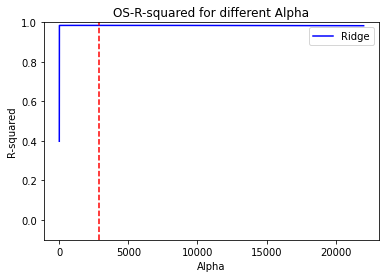

Runtime of the program is 7257.294276475906


In [71]:
import time
# starting time
start = time.time()
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(1,X_train,y_train,X_test,y_test,alphas,Graph=True, logl=False)
end = time.time()
print(f"Runtime of the program is {end - start}")

In [92]:
best_params = pd.Series(best_coefs, index=X_train.columns).sort_values(ascending=True)
best_params

maxfar_10          -0.003956
yearbuilt_14       -0.002301
housing_units_10   -0.002088
land_use_7.0_12    -0.001962
land_use_10.0_12   -0.001673
                      ...   
low_educ_10         0.001739
land_use_6.0_10     0.001842
yearbuilt_10        0.002281
diff_1012_maxfar    0.147640
diff_1214_maxfar    0.688095
Length: 117, dtype: float64

# Random Forest

In [21]:
model=pd.merge(model,keys,on='bbl',how='inner')

In [121]:
statistics.mean([2,4,3])

3

# Residential estimation

In [122]:
import time
start = time.time()
borough=list(model.borough.unique())
ISr=[]
OSr=[]
feature_impr=[]
for b in borough:
    print(b)
    model_df=model[model.borough==b]
    model_df=model_df.iloc[:,2:-7]
    X,y=features(model_df,'Residential')
    IS_mean=[]
    OS_mean=[]
    stop=False
    while stop=False:
        X_train, X_test, y_train, y_test = train_test_split_(X,y,0.35)
        X_train,X_test=scaling(X_train,X_test)
        
        # starting time
        
        IS_r2,OS_r2,importances=random_forest(X_train,X_test,y_train,y_test)
        IS_mean.append(IS_r2)
        OS_mean.append(OS_r2)
        
        
        
        print(f"In sample: {IS_mean} , Out of sample: {OS_mean}")
    ISr.append(statistics.mean(IS_mean))
    OSr.append(statistics.mean(OS_mean))
    feature_impr.append(importances)    
    end = time.time()
    t=(end-start)/60
    print(f"Runtime of the program is {t}")
print(f"In smaple mean{ISr}")
print(f"In smaple mean{OSr}")

BX
In sample: [0.9595246734888165] , Out of sample: [0.8921030177897877]
In sample: [0.9595246734888165, 0.9795370257435999] , Out of sample: [0.8921030177897877, 0.9485877731849147]
In sample: [0.9595246734888165, 0.9795370257435999, 0.9504837259149188] , Out of sample: [0.8921030177897877, 0.9485877731849147, 0.9429116782230103]
In sample: [0.9595246734888165, 0.9795370257435999, 0.9504837259149188, 0.9772590918181331] , Out of sample: [0.8921030177897877, 0.9485877731849147, 0.9429116782230103, 0.9690201455144855]
In sample: [0.9595246734888165, 0.9795370257435999, 0.9504837259149188, 0.9772590918181331, 0.9894418671232815] , Out of sample: [0.8921030177897877, 0.9485877731849147, 0.9429116782230103, 0.9690201455144855, 0.9358552446354419]
In sample: [0.9595246734888165, 0.9795370257435999, 0.9504837259149188, 0.9772590918181331, 0.9894418671232815, 0.9621396925842952] , Out of sample: [0.8921030177897877, 0.9485877731849147, 0.9429116782230103, 0.9690201455144855, 0.935855244635441

In sample: [0.856388499876642, 0.9043075249148215, 0.9221936590434616, 0.8642437207458045, 0.8763459013888074, 0.8165074461207774] , Out of sample: [0.9200614083278466, 0.8958873615720467, 0.9141686479454252, 0.9097558916387571, 0.8939520010469391, 0.8854406483992903]
In sample: [0.856388499876642, 0.9043075249148215, 0.9221936590434616, 0.8642437207458045, 0.8763459013888074, 0.8165074461207774, 0.9886986491507017] , Out of sample: [0.9200614083278466, 0.8958873615720467, 0.9141686479454252, 0.9097558916387571, 0.8939520010469391, 0.8854406483992903, 0.003129576289948477]
In sample: [0.856388499876642, 0.9043075249148215, 0.9221936590434616, 0.8642437207458045, 0.8763459013888074, 0.8165074461207774, 0.9886986491507017, 0.8243175989820135] , Out of sample: [0.9200614083278466, 0.8958873615720467, 0.9141686479454252, 0.9097558916387571, 0.8939520010469391, 0.8854406483992903, 0.003129576289948477, 0.8642684891892993]
In sample: [0.856388499876642, 0.9043075249148215, 0.9221936590434616

In [142]:
# Whole city
model_df

,easements_10,lotarea_10,lotfront_10,lotdepth_10,assessland_10,assesstot_10,yearbuilt_10,builtfar_10,med_income_10,housing_units_10,...,diff_1214_maxfar,diff_1214_comm_built_far,diff_1214_res_built_far,diff_1214_office_built_far,diff_1214_retail_built_far,diff_1214_garage_built_far,diff_1214_storage_built_far,diff_1214_factry_built_far,comm_built_far_17,res_built_far_17
690774,0,30195,183.0,165.0,153000.0,207000.0,1987,0.03,72905.0,284.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.026494,0.000000
690775,0,136600,299.0,457.0,337500.0,585000.0,1975,0.26,72905.0,284.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.287094,0.000000
690776,0,15000,50.0,300.0,43875.0,57150.0,1955,0.22,72905.0,284.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.224000,0.000000
690777,0,36270,670.0,125.0,81450.0,224550.0,1972,0.36,72905.0,284.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.358423,0.000000
690778,1,681100,903.0,892.0,3217500.0,7560000.0,1990,0.37,72905.0,284.0,...,1.4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.374286,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802175,0,5000,50.0,100.0,14128.0,24177.0,1960,0.55,68333.0,502.0,...,0.4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.550400
802176,0,3100,29.0,112.0,12007.0,19578.0,1999,0.60,68333.0,502.0,...,0.4,0.0,-0.112903,0.0,0.0,0.0,0.0,0.0,0.000000,0.490000
802177,0,1400,14.0,100.0,11444.0,16336.0,1986,0.80,68333.0,502.0,...,0.4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.800000
802178,0,2475,23.0,100.0,15420.0,26460.0,2000,0.89,68333.0,502.0,...,0.4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.595556


In [143]:
model_df=model.iloc[:,2:-7]
import time
start = time.time()
borough=list(model.borough.unique())
ISr=[]
OSr=[]
feature_impr=[]
X,y=features(model_df,'Residential')
IS_mean=[]
OS_mean=[]
stop=False
while stop==False:
    rf=RandomForestRegressor().fit(X,y)
    importances=rf.feature_importances_
    predict=rf.predict(X)
    r2=rf.score(X,y)
    stop=True

In [144]:
r2

0.9071153908948372

In [147]:
model['predict']=predict

In [198]:
dirnta=r'C:\Users\Jose Ramon Romero P\Documents\NYU\Semester 2\Capstone 1\NYC-Rezoning-evaluation\data\mappluto_nyc\mappluto_nyc\2010 Neighborhood Tabulation Areas (NTAs)'
nta=gpd.read_file(dirnta+'/NTA.shp')

In [200]:
nta

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227887,"POLYGON ((-73.97605 40.63128, -73.97717 40.630..."
1,4.0,Queens,081,QN51,Murray Hill,5.248828e+07,33266.904952,"POLYGON ((-73.80379 40.77561, -73.80099 40.775..."
2,4.0,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.711764,"POLYGON ((-73.86110 40.76366, -73.85993 40.762..."
3,3.0,Brooklyn,047,BK23,West Brighton,8.738769e+06,14113.581565,"POLYGON ((-73.96889 40.57526, -73.96895 40.575..."
4,4.0,Queens,081,QN41,Fresh Meadows-Utopia,2.777485e+07,22106.431272,"POLYGON ((-73.77758 40.73019, -73.77849 40.729..."
...,...,...,...,...,...,...,...,...
190,4.0,Queens,081,QN12,Hammels-Arverne-Edgemere,6.189578e+07,83075.615293,"POLYGON ((-73.76810 40.59785, -73.76795 40.597..."
191,1.0,Manhattan,061,MN22,East Village,1.089424e+07,13555.232097,"POLYGON ((-73.98378 40.72154, -73.98382 40.721..."
192,1.0,Manhattan,061,MN23,West Village,2.497065e+07,28621.650882,"POLYGON ((-73.98990 40.73443, -73.98987 40.733..."
193,2.0,Bronx,005,BX14,East Concourse-Concourse Village,1.822164e+07,27199.911891,"POLYGON ((-73.90959 40.84276, -73.90962 40.842..."


<AxesSubplot:>

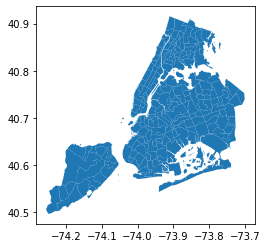

In [199]:
nta.plot()

In [203]:
geo=r'C:\Users\Jose Ramon Romero P\Documents\NYU\Semester 2\Capstone 1\Data\NewYorkCity_complete\NewYorkCity\2017'
mappluto=gpd.read_file(geo+'/mappluto2017.shp')

In [204]:
type(mappluto)

geopandas.geodataframe.GeoDataFrame

In [205]:
mappluto=pd.merge(mappluto,model,left_on='BBL',right_on='bbl',how='inner')

In [206]:
mappluto['diff_1017_res']=mappluto['res_built_far_17']-mappluto['res_built_far_10']

<AxesSubplot:>

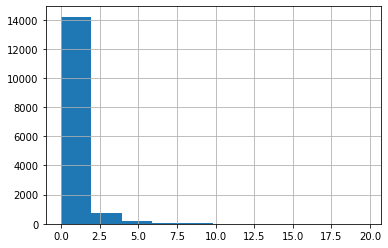

In [207]:
(mappluto['diff_1017_res'][(mappluto['diff_1017_res']>0) & (mappluto['diff_1017_res']<20)]).hist()

In [208]:
mappluto['diff_pred']=mappluto['res_built_far_17']-mappluto['predict']

In [209]:
mappluto['diff_10_pred']=mappluto['predict']-mappluto['res_built_far_10']

In [211]:
dataviz

NameError: name 'dataviz' is not defined

In [212]:
mappluto=[]

In [213]:
model_df=[]

In [194]:
mappluto.to_file(r'C:\Users\Jose Ramon Romero P\Documents\NYU\Semester 2\Capstone 1\NYC-Rezoning-evaluation\data\mappluto_nyc\mappluto_nyc\predict_res.shp')


In [145]:
X

,lotarea_10,lotfront_10,lotdepth_10,assessland_10,assesstot_10,yearbuilt_10,builtfar_10,med_income_10,housing_units_10,subway_acc_10,...,diff_1214_assesstot,diff_1214_builtfar,diff_1214_maxfar,diff_1214_comm_built_far,diff_1214_res_built_far,diff_1214_office_built_far,diff_1214_retail_built_far,diff_1214_garage_built_far,diff_1214_storage_built_far,diff_1214_factry_built_far
0,45053,301.42,76.58,270450.0,297900.0,1931,0.02,0.0,0.0,7720.114746,...,21150.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,133700,333.08,430.00,450000.0,1804500.0,1966,0.62,0.0,0.0,7720.114746,...,178650.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,350500,377.00,986.00,3154500.0,63900000.0,1999,1.27,0.0,0.0,7720.114746,...,3043800.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,54543,439.87,124.00,268650.0,1300500.0,1952,0.88,0.0,0.0,7720.114746,...,235350.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,153200,197.00,567.58,765000.0,2326500.0,1967,0.64,0.0,0.0,7720.114746,...,267750.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802175,5000,50.00,100.00,14128.0,24177.0,1960,0.55,68333.0,502.0,389.843536,...,-2023.0,0.00,0.4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
802176,3100,29.00,112.00,12007.0,19578.0,1999,0.60,68333.0,502.0,389.843536,...,365.0,-0.11,0.4,0.0,-0.112903,0.0,0.0,0.0,0.0,0.0
802177,1400,14.00,100.00,11444.0,16336.0,1986,0.80,68333.0,502.0,389.843536,...,-3540.0,0.00,0.4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
802178,2475,23.00,100.00,15420.0,26460.0,2000,0.89,68333.0,502.0,389.843536,...,-4664.0,0.00,0.4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [140]:
r2

0.9493169536017808

In [129]:
forest_importances_r = pd.DataFrame(feature_impr, columns=X_train.columns,index=borough)
forest_importances_r=forest_importances_r.T

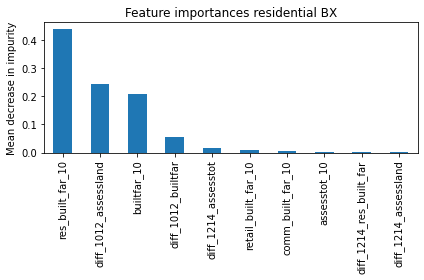

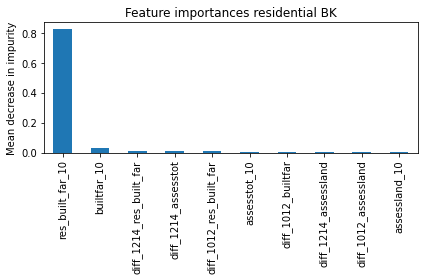

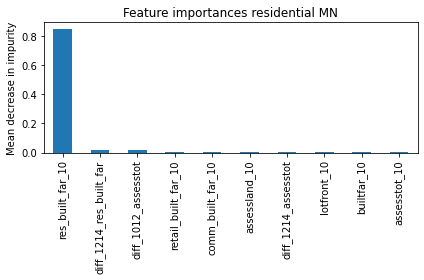

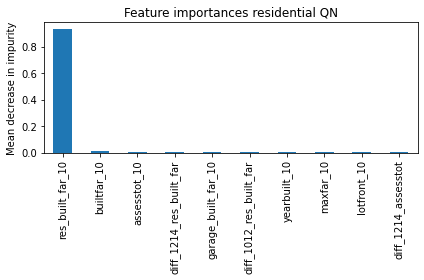

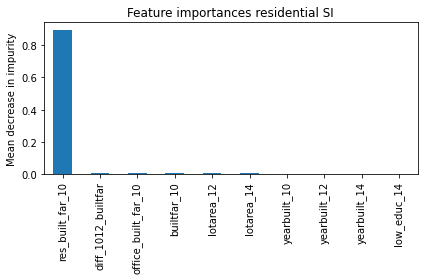

In [130]:
import pandas as pd
for b in borough:
    forest_importances_r=forest_importances_r.sort_values(by=b,ascending=False)
    fig, ax = plt.subplots()
    forest_importances_r[b][:10].plot.bar( ax=ax)
    ax.set_title("Feature importances {} {}".format('residential',b))
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    fig.savefig(b+'residential.png')

# Commercial estimation

In [125]:

borough=list(model.borough.unique())
ISc=[]
OSc=[]
feature_impc=[]
for b in borough:
    print(b)
    model_df=model[model.borough==b]
    model_df=model_df.iloc[:,2:-7]
    X,y=features(model_df,'Commercial')
    IS_mean=[]
    OS_mean=[]
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split_(X,y,0.35)
        X_train,X_test=scaling(X_train,X_test)
        import time
        # starting time
        start = time.time()
        IS_r2,OS_r2,importances=random_forest(X_train,X_test,y_train,y_test)
        IS_mean.append(IS_r2)
        OS_mean.append(OS_r2)
        print(f"In sample: {IS_mean} , Out of sample: {OS_mean}")
    ISc.append(statistics.mean(IS_mean))
    OSc.append(statistics.mean(OS_mean))
    feature_impc.append(importances)   
    end = time.time()
    t=(end-start)/3600
    print(f"Runtime of the program is {t}")
print(f"In smaple mean{ISc}")
print(f"In smaple mean{OSc}")

BX
In sample: [0.9568048214451295] , Out of sample: [0.9699680671031242]
In sample: [0.9568048214451295, 0.9678373523922617] , Out of sample: [0.9699680671031242, 0.9474420105676284]
In sample: [0.9568048214451295, 0.9678373523922617, 0.9772714123840611] , Out of sample: [0.9699680671031242, 0.9474420105676284, 0.9257456146213668]
In sample: [0.9568048214451295, 0.9678373523922617, 0.9772714123840611, 0.985566840701669] , Out of sample: [0.9699680671031242, 0.9474420105676284, 0.9257456146213668, 0.9525899237357898]
In sample: [0.9568048214451295, 0.9678373523922617, 0.9772714123840611, 0.985566840701669, 0.9820967963442345] , Out of sample: [0.9699680671031242, 0.9474420105676284, 0.9257456146213668, 0.9525899237357898, 0.825857506944248]
In sample: [0.9568048214451295, 0.9678373523922617, 0.9772714123840611, 0.985566840701669, 0.9820967963442345, 0.9793050849805186] , Out of sample: [0.9699680671031242, 0.9474420105676284, 0.9257456146213668, 0.9525899237357898, 0.825857506944248, 0.

In sample: [0.9934016294287944, 0.9945133110316943, 0.9936204258089841, 0.8328081356735957, 0.9932141096722781, 0.9942007528851139] , Out of sample: [0.003775306463277839, 0.004938617879326479, 0.004773336734056666, 0.9554887363538178, 0.005537647279134306, 0.0053828701124980505]
In sample: [0.9934016294287944, 0.9945133110316943, 0.9936204258089841, 0.8328081356735957, 0.9932141096722781, 0.9942007528851139, 0.994197266991858] , Out of sample: [0.003775306463277839, 0.004938617879326479, 0.004773336734056666, 0.9554887363538178, 0.005537647279134306, 0.0053828701124980505, 0.00534837402860433]
In sample: [0.9934016294287944, 0.9945133110316943, 0.9936204258089841, 0.8328081356735957, 0.9932141096722781, 0.9942007528851139, 0.994197266991858, 0.8623005819333278] , Out of sample: [0.003775306463277839, 0.004938617879326479, 0.004773336734056666, 0.9554887363538178, 0.005537647279134306, 0.0053828701124980505, 0.00534837402860433, 0.9565113713314722]
In sample: [0.9934016294287944, 0.994

In [126]:
forest_importances_c = pd.DataFrame(feature_impc, columns=X_train.columns,index=borough)
forest_importances_c=forest_importances_c.T


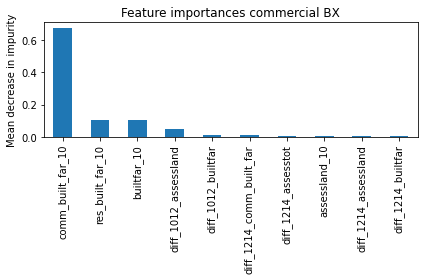

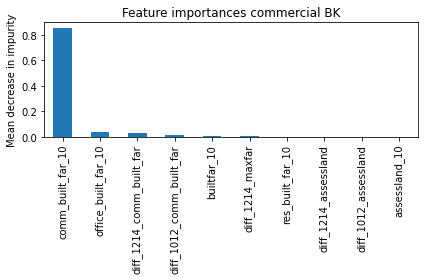

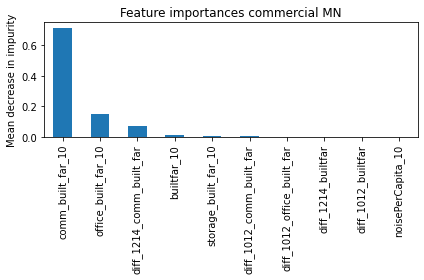

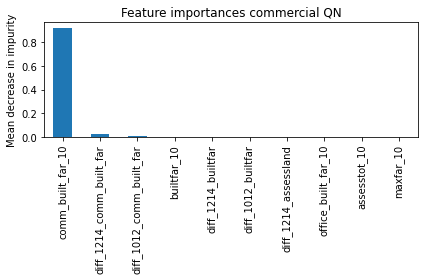

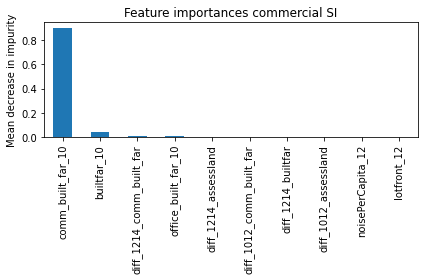

In [127]:
import pandas as pd
for b in borough:
    forest_importances_c=forest_importances_c.sort_values(by=b,ascending=False)
    fig, ax = plt.subplots()
    forest_importances_c[b][:10].plot.bar( ax=ax)
    ax.set_title("Feature importances {} {}".format('commercial',b))
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    fig.savefig(b+'commercial.png')

In [ ]:
model.to_csv(r'C:\Users\Jose Ramon Romero P\Documents\NYU\Semester 2\Capstone 1\NYC-Rezoning-evaluation\data\mappluto_nyc\mappluto_nyc\model_viz.csv')